## 1.数据获取

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import akshare as ak
import time
import os
from tqdm import tqdm  # 导入 tqdm 用于显示进度条

start_date = '20150101'
end_date = '20241231'

# 1.获取四个指数换手率的数据
SZ50_index = ak.index_zh_a_hist(symbol="000016", period="daily", start_date=start_date, end_date=end_date)
HS300_index = ak.index_zh_a_hist(symbol="000300", period="daily", start_date=start_date, end_date=end_date)
ZZ1000_index = ak.index_zh_a_hist(symbol="000852", period="daily", start_date=start_date, end_date=end_date)
ZZ2000_index = ak.index_zh_a_hist(symbol="932000", period="daily", start_date=start_date, end_date=end_date)

# 提取 date 和换手率，并设置 date 为索引
turnover_SZ50 = SZ50_index[["日期", "换手率"]].rename(columns={"日期": "date", "换手率": "SZ50"}).set_index("date")
turnover_HS300 = HS300_index[["日期", "换手率"]].rename(columns={"日期": "date", "换手率": "HS300"}).set_index("date")
turnover_ZZ1000 = ZZ1000_index[["日期", "换手率"]].rename(columns={"日期": "date", "换手率": "ZZ1000"}).set_index("date")
turnover_ZZ2000 = ZZ2000_index[["日期", "换手率"]].rename(columns={"日期": "date", "换手率": "ZZ2000"}).set_index("date")

# 合并数据
combined_turnover = pd.concat([turnover_SZ50, turnover_HS300, turnover_ZZ1000, turnover_ZZ2000], axis=1)

# 2.获取沪深300指数收盘价数据
HS300_index_data = HS300_index[["日期", "收盘"]].rename(columns={"日期": "date", "收盘": "close"}).set_index("date")

In [2]:
def merge_turnover_with_index(combined_turnover, index_data):
    """
    将市场成交数据与指数数据合并。
    
    参数：
    combined_turnover: 包含换手率数据的DataFrame，日期为索引
    index_data (DataFrame): 包含 'close' 列的指数数据，日期为索引
    
    返回：
    DataFrame: 合并后的数据
    """
    # 确保两个数据框的索引都是日期类型
    combined_turnover.index = pd.to_datetime(combined_turnover.index)
    index_data.index = pd.to_datetime(index_data.index)

    # 筛选2016年之后的数据
    combined_turnover_filtered = combined_turnover[combined_turnover.index > "2016-01-01"].copy()

    # 添加四列计算结果
    combined_turnover_filtered['ZZ1000/SZ50'] = combined_turnover_filtered['ZZ1000'] / combined_turnover_filtered['SZ50']
    combined_turnover_filtered['ZZ1000/HS300'] = combined_turnover_filtered['ZZ1000'] / combined_turnover_filtered['HS300']
    combined_turnover_filtered['ZZ2000/SZ50'] = combined_turnover_filtered['ZZ2000'] / combined_turnover_filtered['SZ50']
    combined_turnover_filtered['ZZ2000/HS300'] = combined_turnover_filtered['ZZ2000'] / combined_turnover_filtered['HS300']

    # 合并数据，左连接
    aligned_data = combined_turnover_filtered.merge(
        index_data[['close']],  # 只保留 'close' 列
        how='left',             # 以 combined_turnover_filtered 为主
        left_index=True,        # 基于索引对齐
        right_index=True        # 基于索引对齐
    )
    
    return aligned_data

# 调用函数合并数据
aligned_turnover = merge_turnover_with_index(combined_turnover, HS300_index_data)


## 2.PCA合成换手率相关指数

In [3]:
# 导入必要的库
from sklearn.decomposition import PCA
import numpy as np

def calc_sentiment_PCA_1(turnover_df):
    """
    使用PCA方法计算合成指数（第一步）
    
    参数:
    turnover_df (DataFrame): 包含换手率数据的DataFrame
    
    返回:
    DataFrame: 标准化后的数据
    """
    # 选择用于PCA的列（换手率比率）
    pca_columns = ['ZZ1000/SZ50', 'ZZ1000/HS300', 'ZZ2000/SZ50', 'ZZ2000/HS300']
    sent_comps_df = turnover_df[pca_columns].copy()
    
    # 数据标准化（零均值，单位方差）
    sent_comps_df = (sent_comps_df - sent_comps_df.mean()) / sent_comps_df.std()
    
    # 应用PCA
    pca = PCA(n_components=1)
    pca_comp = pca.fit_transform(sent_comps_df)
    
    # 计算每个因子与主成分的相关性
    corr_values = []
    for column in sent_comps_df.columns:
        corr_value = np.corrcoef(pca_comp.T[0], np.array(sent_comps_df[column]))[0, 1]
        corr_values.append((column, corr_value))
        print(f"{column}: {corr_value:.4f}")
    
    # 将PCA结果添加到原始数据中
    turnover_df['sentiment_pca1'] = pca_comp
    
    return turnover_df

def calc_sentiment_PCA_2(turnover_df):
    """
    使用滚动PCA方法计算合成指数（第二步）
    
    参数:
    turnover_df (DataFrame): 包含第一步PCA结果的数据框
    
    返回:
    DataFrame: 包含最终合成指数的数据框
    """
    # 选择用于PCA的列
    pca_columns = ['ZZ1000/SZ50', 'ZZ1000/HS300', 'ZZ2000/SZ50', 'ZZ2000/HS300']
    sent_comps_df = turnover_df[pca_columns].copy()
    
    # 标准化数据
    sent_comps_df = (sent_comps_df - sent_comps_df.mean()) / sent_comps_df.std()
    
    # 检查数据
    if sent_comps_df.isnull().any().any():
        raise ValueError("输入数据包含NaN值")
    zero_std_cols = sent_comps_df.std()[sent_comps_df.std() == 0].index
    if len(zero_std_cols) > 0:
        raise ValueError(f"存在标准差为0的列: {list(zero_std_cols)}")
    
    sentiment_index = []
    
    # 对每个交易日进行滚动PCA
    for trade_date in sent_comps_df.index[2:]:
        pca = PCA(n_components=1)
        # 使用截至当前日期的所有数据
        temp_df = sent_comps_df.loc[:trade_date]
        
        # 确保数据没有问题
        assert not temp_df.isnull().any().any(), f"在{trade_date}的数据中发现NaN值"
        pca_comp = pca.fit_transform(temp_df)
        
        # 标准化PCA结果
        pca_comp = (pca_comp - np.mean(pca_comp)) / np.std(pca_comp)
        assert not np.isnan(pca_comp).any(), f"在{trade_date}的PCA计算中发现NaN值"
        
        sentiment_index.append(pca_comp[-1])
    
    # 创建合成指数DataFrame
    sentiment_index_df = pd.DataFrame(sentiment_index, 
                                    index=sent_comps_df.index[2:], 
                                    columns=['sentiment_index'])
    
    # 将合成指数添加到原始数据中
    turnover_df = turnover_df.join(sentiment_index_df)
    
    return turnover_df

# 计算合成指数
print("第一步：计算基础PCA合成指数")
aligned_turnover_index = calc_sentiment_PCA_1(aligned_turnover)

print("\n第二步：计算滚动PCA合成指数")
turnover_index = calc_sentiment_PCA_2(aligned_turnover_index)


第一步：计算基础PCA合成指数
ZZ1000/SZ50: 0.8300
ZZ1000/HS300: 0.8820
ZZ2000/SZ50: 0.9210
ZZ2000/HS300: 0.8781

第二步：计算滚动PCA合成指数


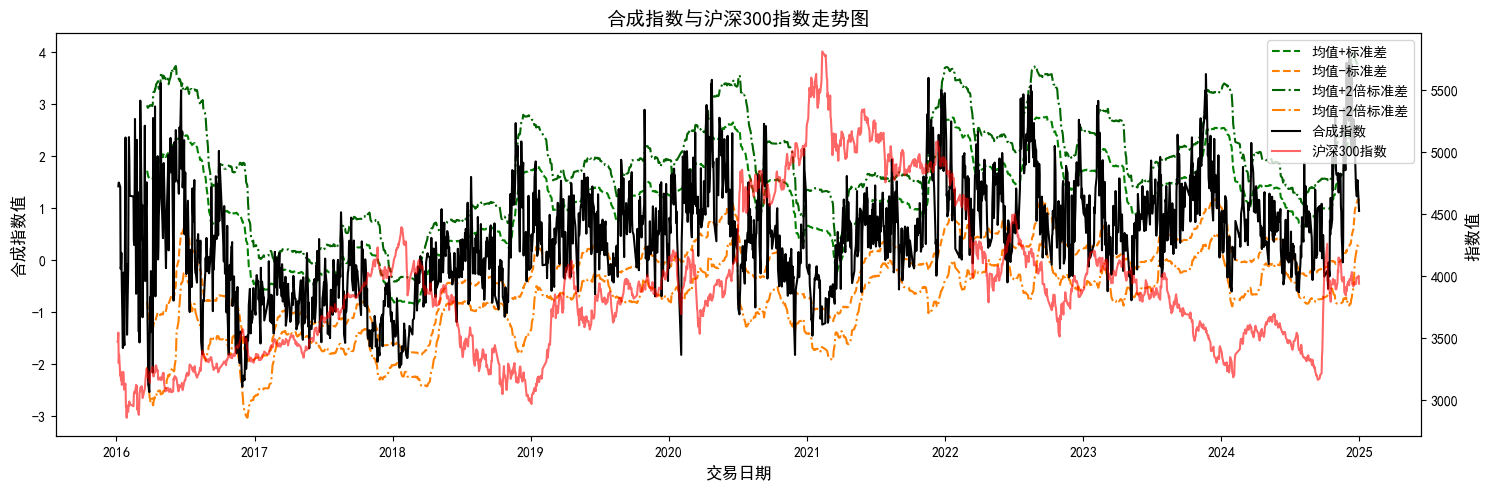

In [4]:
# 设置matplotlib支持中文显示
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

def plot_sentiment(df, index_df, sentiment_col='sentiment_index', title='合成指数走势图'):
    """
    绘制合成指数和沪深300指数的走势图，包含均值和标准差带
    
    参数:
    df (DataFrame): 包含合成指数的数据框，日期为索引
    index_df (DataFrame): 包含沪深300收盘价的数据框，日期为索引
    sentiment_col (str): 合成指数的列名
    title (str): 图表标题
    """
    # 确保索引是日期类型
    df.index = pd.to_datetime(df.index)
    index_df.index = pd.to_datetime(index_df.index)
    
    # 获取起始日期
    start_date = df.index[0].strftime('%Y-%m-%d')
    
    # 计算均值和标准差带
    mean_df = df[[sentiment_col]].rolling(50).mean()
    std_df = df[[sentiment_col]].rolling(50).std()
    
    upper_bound_df = mean_df + std_df
    lower_bound_df = mean_df - std_df
    two_upper_bound_df = mean_df + 2 * std_df
    two_lower_bound_df = mean_df - 2 * std_df

    # 创建图表
    fig, ax1 = plt.subplots(figsize=(15, 5))

    # 绘制合成指数和标准差带
    ax1.plot(upper_bound_df.index, upper_bound_df[sentiment_col], 
             ls='--', color=(0, 0.5, 0, 1), label='均值+标准差')
    ax1.plot(lower_bound_df.index, lower_bound_df[sentiment_col], 
             ls='--', color=(1, 0.5, 0, 1), label='均值-标准差')
    ax1.plot(two_upper_bound_df.index, two_upper_bound_df[sentiment_col], 
             ls='-.', color='darkgreen', label='均值+2倍标准差')
    ax1.plot(two_lower_bound_df.index, two_lower_bound_df[sentiment_col], 
             ls='-.', color=(1, 0.5, 0, 1), label='均值-2倍标准差')
    ax1.plot(df.index, df[sentiment_col], 
             color=(0, 0, 0, 1), label='合成指数')
    
    ax1.set_xlabel('交易日期', fontsize=12)
    ax1.set_ylabel('合成指数值', fontsize=12)
    
    # 设置x轴主刻度为年份
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # 添加沪深300指数
    ax2 = ax1.twinx()
    index_df_filtered = index_df[start_date:]
    ax2.plot(index_df_filtered.index, 
             index_df_filtered['close'], 
             color=(1, 0, 0, 0.6), label='沪深300指数')

    ax2.set_ylabel("指数值", fontsize=12)

    # 合并两个y轴的图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)

    plt.title(title, fontsize=14)
    fig.tight_layout()
    plt.show()

# 绘制合成指数走势图
plot_sentiment(turnover_index, HS300_index_data, 
              sentiment_col='sentiment_index', 
              title='合成指数与沪深300指数走势图')

## 3.计算信号因子

In [5]:
def calculate_trading_signals(df, sentiment_col='sentiment_index', window=50):
    """
    根据合成指数计算交易信号
    
    参数:
    df (DataFrame): 包含合成指数的数据框
    sentiment_col (str): 合成指数的列名
    window (int): 计算移动平均和标准差的窗口大小，默认50天
    
    返回:
    DataFrame: 包含原始数据和交易信号的数据框
    """
    # 复制数据框以避免修改原始数据
    signals_df = df.copy()
    
    # 计算移动平均和标准差
    mean_df = signals_df[[sentiment_col]].rolling(window).mean()
    std_df = signals_df[[sentiment_col]].rolling(window).std()
    
    # 计算标准差带
    upper_2std = mean_df + 2 * std_df
    upper_1std = mean_df + 1 * std_df
    lower_1std = mean_df - 1 * std_df
    lower_2std = mean_df - 2 * std_df
    
    # 初始化信号列
    signals_df['signal'] = 0.0
    
    # 生成交易信号
    # 1. 超过mean+2std为卖出信号(-1)
    sell_2std = signals_df[sentiment_col] > upper_2std[sentiment_col]
    signals_df.loc[sell_2std, 'signal'] = -1.0
    
    # 2. 低于mean-2std为买入信号(1)
    buy_2std = signals_df[sentiment_col] < lower_2std[sentiment_col]
    signals_df.loc[buy_2std, 'signal'] = 1.0
    
    # 3. mean+2std到mean+1std之间为卖出-0.5持仓
    sell_1std = (signals_df[sentiment_col] > upper_1std[sentiment_col]) & \
                (signals_df[sentiment_col] <= upper_2std[sentiment_col])
    signals_df.loc[sell_1std, 'signal'] = -0.5
    
    # 4. mean-2std到mean-1std之间为买入-0.5持仓
    buy_1std = (signals_df[sentiment_col] < lower_1std[sentiment_col]) & \
               (signals_df[sentiment_col] >= lower_2std[sentiment_col])
    signals_df.loc[buy_1std, 'signal'] = 0.5
    
    # 添加信号说明列
    signals_df['signal_desc'] = '中性'
    signals_df.loc[signals_df['signal'] == 1.0, 'signal_desc'] = '强烈买入'
    signals_df.loc[signals_df['signal'] == 0.5, 'signal_desc'] = '温和买入'
    signals_df.loc[signals_df['signal'] == -0.5, 'signal_desc'] = '温和卖出'
    signals_df.loc[signals_df['signal'] == -1.0, 'signal_desc'] = '强烈卖出'
    
    return signals_df

# 计算交易信号
signals_df = calculate_trading_signals(turnover_index, sentiment_col='sentiment_index')

## 4.计算信号因子效果与收益率情况

In [12]:
import pandas as pd
import numpy as np

def calculate_returns(signals_df, index_df, signal_col='signal', close_col='close'):
    """
    计算策略收益率和基准收益率
    
    参数:
    signals_df (DataFrame): 包含交易信号的数据框
    index_df (DataFrame): 包含指数收盘价的数据框
    signal_col (str): 信号列名
    close_col (str): 收盘价列名
    
    返回:
    DataFrame: 包含收益率数据的数据框
    """
    # 复制数据框以避免修改原始数据
    returns_df = signals_df.copy()
    
    # 确保索引是日期类型
    returns_df.index = pd.to_datetime(returns_df.index)
    index_df.index = pd.to_datetime(index_df.index)
    
    # 计算指数收益率
    index_df['benchmark_return'] = index_df[close_col].pct_change()
    
    # 计算策略收益率（信号 * 指数收益率）
    returns_df['strategy_return'] = returns_df[signal_col] * index_df['benchmark_return']
    
    # 计算累积收益率
    returns_df['cumulative_benchmark_return'] = (1 + index_df['benchmark_return']).cumprod() - 1
    returns_df['cumulative_strategy_return'] = (1 + returns_df['strategy_return']).cumprod() - 1
    
    # 计算年化收益率
    def calculate_annualized_return(returns):
        # 使用日收益率计算年化收益率
        daily_mean = returns.mean()
        return (1 + daily_mean) ** 252 - 1  # 使用252个交易日
    
    annual_benchmark_return = calculate_annualized_return(index_df['benchmark_return'])
    annual_strategy_return = calculate_annualized_return(returns_df['strategy_return'])
     
    # 计算最大回撤
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative - running_max) / running_max
        return drawdown.min()
    
    benchmark_drawdown = calculate_max_drawdown(index_df['benchmark_return'])
    strategy_drawdown = calculate_max_drawdown(returns_df['strategy_return'])
    
    # 计算夏普比率
    def calculate_sharpe_ratio(returns, risk_free_rate=0):
        excess_returns = returns - risk_free_rate/252  # 日化无风险利率
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    benchmark_sharpe = calculate_sharpe_ratio(index_df['benchmark_return'])
    strategy_sharpe = calculate_sharpe_ratio(returns_df['strategy_return'])
    
    # 计算年化波动率
    def calculate_annualized_volatility(returns):
        return returns.std() * np.sqrt(252)
    
    benchmark_volatility = calculate_annualized_volatility(index_df['benchmark_return'])
    strategy_volatility = calculate_annualized_volatility(returns_df['strategy_return'])
    
    # 创建评估指标表
    metrics_df = pd.DataFrame({
        '指标': ['年化收益率', '最大回撤', '夏普比率', '年化波动率'],
        '策略': [annual_strategy_return, strategy_drawdown, strategy_sharpe, strategy_volatility],
        '基准': [annual_benchmark_return, benchmark_drawdown, benchmark_sharpe, benchmark_volatility]
    })
    
    return returns_df, metrics_df

# 计算收益率
returns_df, metrics_df = calculate_returns(signals_df, HS300_index_data)

# 打印策略评估指标
print("\n策略评估指标：")
metrics_df


策略评估指标：


,指标,策略,基准
0,年化收益率,0.136803,0.033310
1,最大回撤,-0.090774,-0.466961
2,夏普比率,1.634785,0.147741
3,年化波动率,0.078452,0.221800


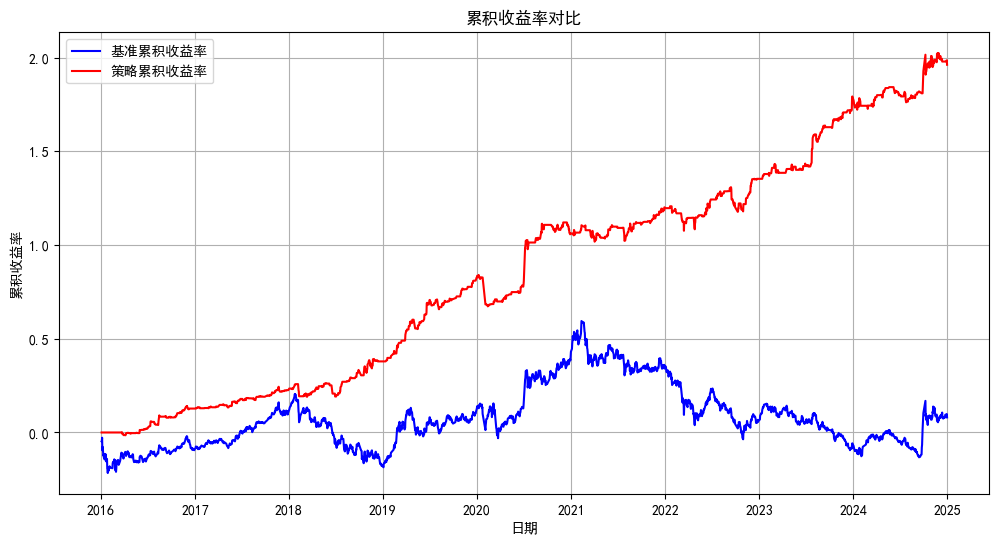

In [13]:
# 可视化累积收益率
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df['cumulative_benchmark_return'], label='基准累积收益率', color='blue')
plt.plot(returns_df.index, returns_df['cumulative_strategy_return'], label='策略累积收益率', color='red')
plt.title('累积收益率对比')
plt.xlabel('日期')
plt.ylabel('累积收益率')
plt.legend()
plt.grid(True)
plt.show()